# Deep Learning with PyTorch - Interactive Tutorial

**Part 2: Building Production-Ready Neural Networks**

This notebook covers:
- Building neural networks with `torch.nn`
- Data loading with `DataLoader`
- Training loops and optimization
- Building and training a CNN on CIFAR-10

In [2]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Check versions
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.9.0+cu126
CUDA available: False
Using device: cpu


## 1. Building Neural Networks with nn.Module

The `nn.Module` class is the foundation of all PyTorch models.

In [3]:
# Simple neural network
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Create model
model = SimpleNet(input_size=784, hidden_size=128, num_classes=10)
print(model)

# Test forward pass
x = torch.randn(32, 784)  # Batch of 32 samples
output = model(x)
print(f"\nInput shape: {x.shape}")
print(f"Output shape: {output.shape}")

SimpleNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Input shape: torch.Size([32, 784])
Output shape: torch.Size([32, 10])


In [4]:
# Inspect model parameters
print("Model parameters:")
for name, param in model.named_parameters():
    print(f"  {name:15s}: {tuple(param.shape)}")

total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

Model parameters:
  fc1.weight     : (128, 784)
  fc1.bias       : (128,)
  fc2.weight     : (10, 128)
  fc2.bias       : (10,)

Total parameters: 101,770


### Exercise 1.1
Create a 3-layer MLP with:
- Input: 100 features
- Hidden layers: 256, 128
- Output: 5 classes
- Use ReLU activations and Dropout(0.2)

In [5]:
# Your code here
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

mlp = MLP()
print(mlp)

MLP(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


## 2. Convolutional Neural Networks

In [6]:
# Simple CNN for image classification
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling and activation
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Conv block 1: 32x32 -> 16x16
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        # Conv block 2: 16x16 -> 8x8
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        # Conv block 3: 8x8 -> 4x4
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

cnn = SimpleCNN()
print(cnn)

# Test with dummy input
x = torch.randn(4, 3, 32, 32)  # 4 RGB images of 32x32
output = cnn(x)
print(f"\nInput: {x.shape} -> Output: {output.shape}")

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Input: torch.Size([4, 3, 32, 32]) -> Output: torch.Size([4, 10])


## 3. Data Loading with DataLoader

In [7]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load training data
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Create data loader
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

print(f"Dataset size: {len(train_dataset)}")
print(f"Number of batches: {len(train_loader)}")

# Get a batch
images, labels = next(iter(train_loader))
print(f"\nBatch shapes:")
print(f"  Images: {images.shape}")
print(f"  Labels: {labels.shape}")

100%|██████████| 170M/170M [00:10<00:00, 16.0MB/s] 


Dataset size: 50000
Number of batches: 782

Batch shapes:
  Images: torch.Size([64, 3, 32, 32])
  Labels: torch.Size([64])


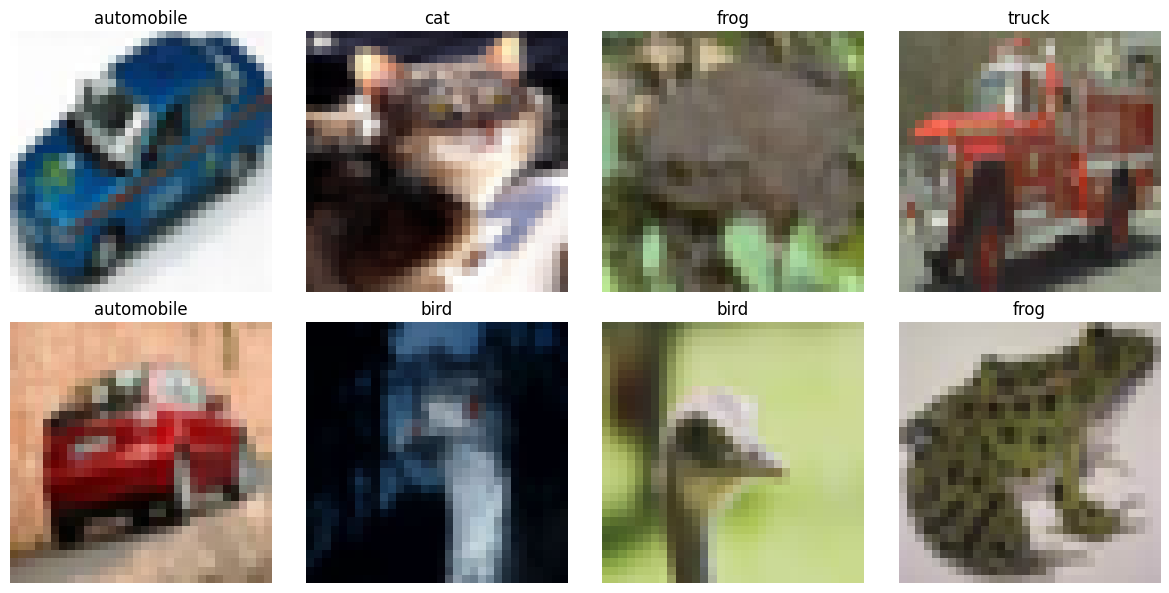

In [8]:
# Visualize some images
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

def imshow(img, title=None):
    img = img / 2 + 0.5  # Denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# Plot first 8 images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for idx in range(8):
    ax = axes[idx]
    plt.sca(ax)
    imshow(images[idx], class_names[labels[idx]])

plt.tight_layout()
plt.show()

## 4. Training Loop

In [9]:
# Training configuration
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

In [10]:
# Train for a few epochs
num_epochs = 5
history = {'loss': [], 'acc': []}

print("Training...")
for epoch in range(num_epochs):
    loss, acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    history['loss'].append(loss)
    history['acc'].append(acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {loss:.4f} | Acc: {acc:.2f}%")

print("\nTraining complete!")

Training...
Epoch [1/5] | Loss: 1.4879 | Acc: 45.25%
Epoch [2/5] | Loss: 1.0924 | Acc: 61.11%
Epoch [3/5] | Loss: 0.9160 | Acc: 67.90%
Epoch [4/5] | Loss: 0.7983 | Acc: 71.96%
Epoch [5/5] | Loss: 0.7144 | Acc: 75.01%

Training complete!


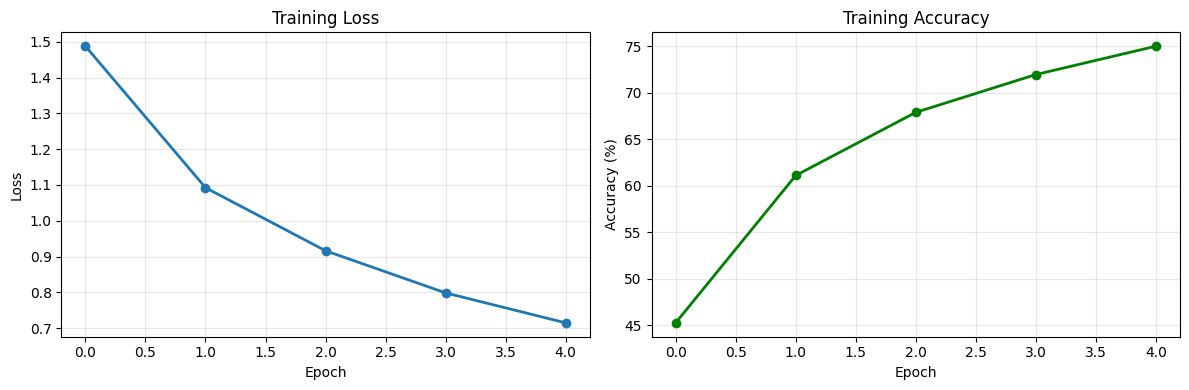

In [11]:
# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(history['loss'], marker='o', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history['acc'], marker='o', linewidth=2, color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Model Evaluation

In [12]:
# Load test dataset
test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

test_acc = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 74.68%


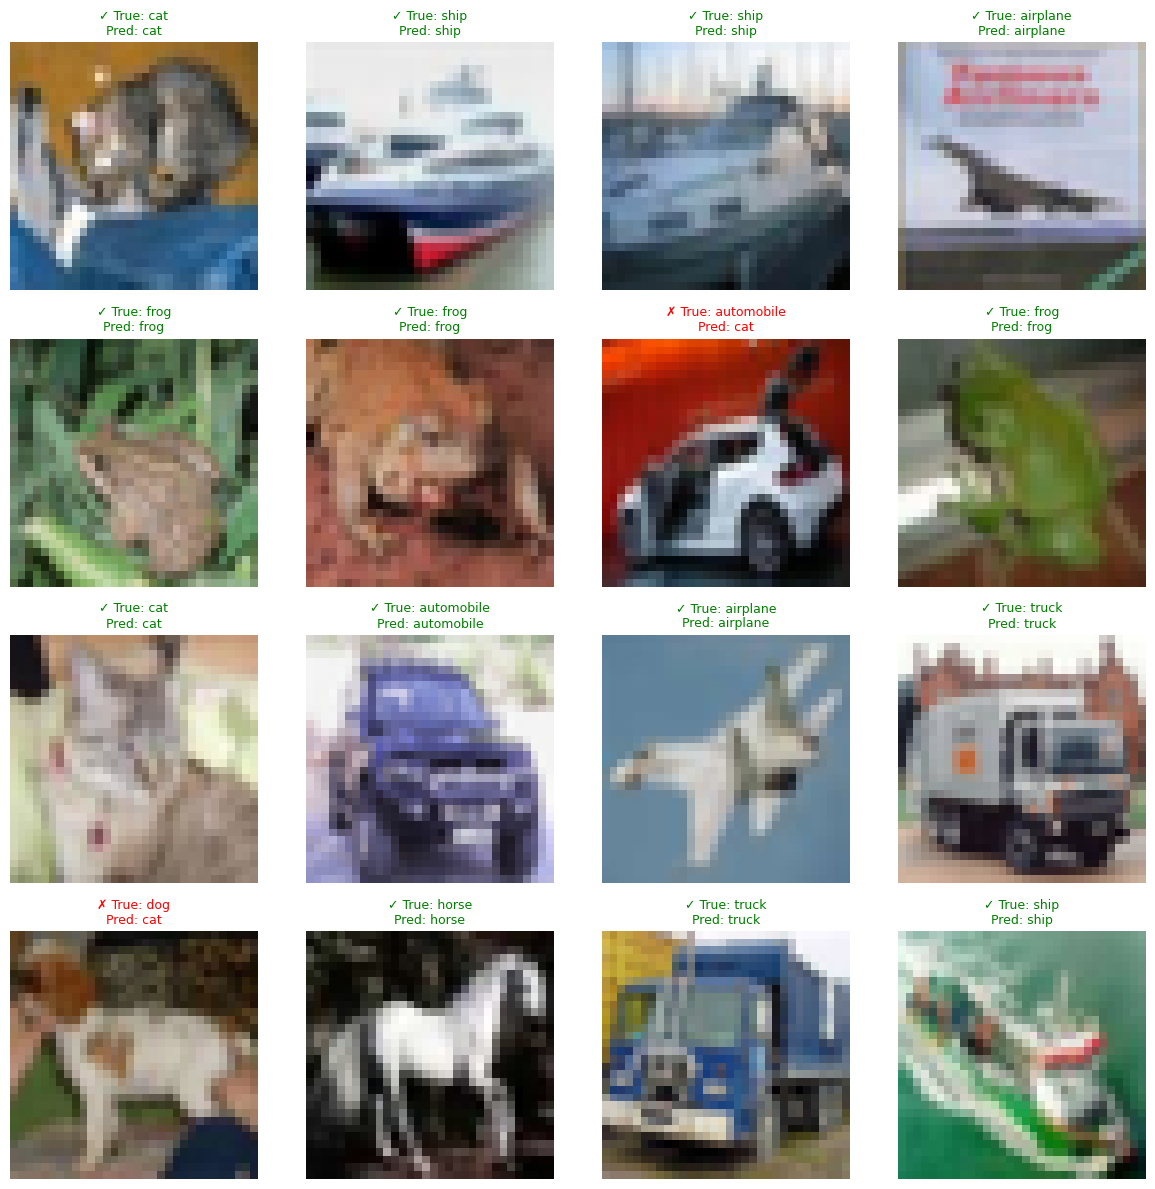

In [13]:
# Visualize predictions
model.eval()
images, labels = next(iter(test_loader))

with torch.no_grad():
    outputs = model(images[:16].to(device))
    _, predictions = torch.max(outputs, 1)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for idx in range(16):
    ax = axes[idx]
    plt.sca(ax)
    
    img = images[idx] / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    true_label = class_names[labels[idx]]
    pred_label = class_names[predictions[idx]]
    
    if labels[idx] == predictions[idx]:
        color = 'green'
        symbol = '✓'
    else:
        color = 'red'
        symbol = '✗'
    
    plt.title(f'{symbol} True: {true_label}\nPred: {pred_label}',
              color=color, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 6. Saving and Loading Models

In [14]:
# Save model
torch.save(model.state_dict(), 'simple_cnn.pth')
print("✓ Model saved to 'simple_cnn.pth'")

# Load model
loaded_model = SimpleCNN().to(device)
loaded_model.load_state_dict(torch.load('simple_cnn.pth'))
loaded_model.eval()
print("✓ Model loaded successfully")

# Verify
test_acc = evaluate(loaded_model, test_loader, device)
print(f"Loaded model test accuracy: {test_acc:.2f}%")

✓ Model saved to 'simple_cnn.pth'
✓ Model loaded successfully
Loaded model test accuracy: 74.68%


## Summary

In this notebook, you learned:

✅ **Building Models:**
- Creating custom `nn.Module` classes
- Convolutional neural networks
- Layer composition patterns

✅ **Data Handling:**
- Using `DataLoader` for batching
- Data transformations and augmentation
- CIFAR-10 dataset

✅ **Training:**
- Training loop structure
- Loss functions and optimizers
- Evaluation and metrics